### Lung segmentation from Chest X-Ray dataset¶
## About the data:

The dataset is made up of images and segmentated mask from two diffrent sources.
There is a slight abnormality in naming convention of masks.

Some images don't have their corresponding masks.
Images from the Shenzhen dataset has apparently smaller lungs as compared to the Montgomery dataset.



In [21]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.

import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
image_path = os.path.join("/home/Desktop/archive/data/Lung Segmentation/CXR_png")
mask_path = os.path.join("/home/Desktop/archive/data/Lung Segmentation/masks")

In [23]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [24]:
len(mask)

704

In [25]:
len(images)

800

In [26]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [27]:

testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [28]:
#perform sanity check

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [29]:
# Load training and testing data
dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [00:39<00:00,  3.52it/s]


### Perform Sanity Check¶
It is prudent to perform sanity check of the data correspondance. It become a routine check-up after a while but it is very crucial to check if we had made a mistake in loading the data.

training set


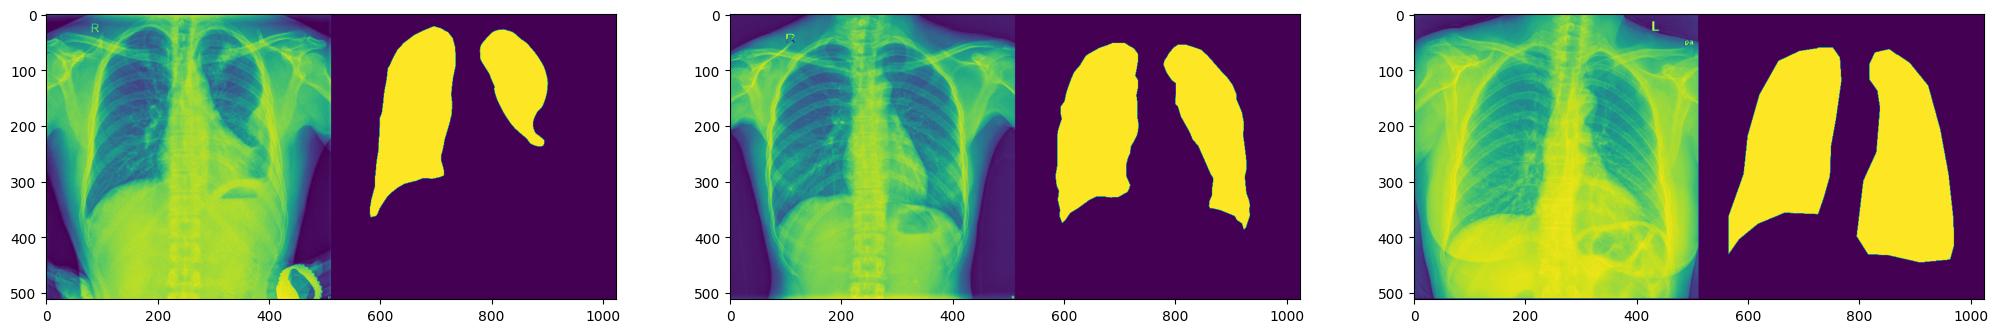

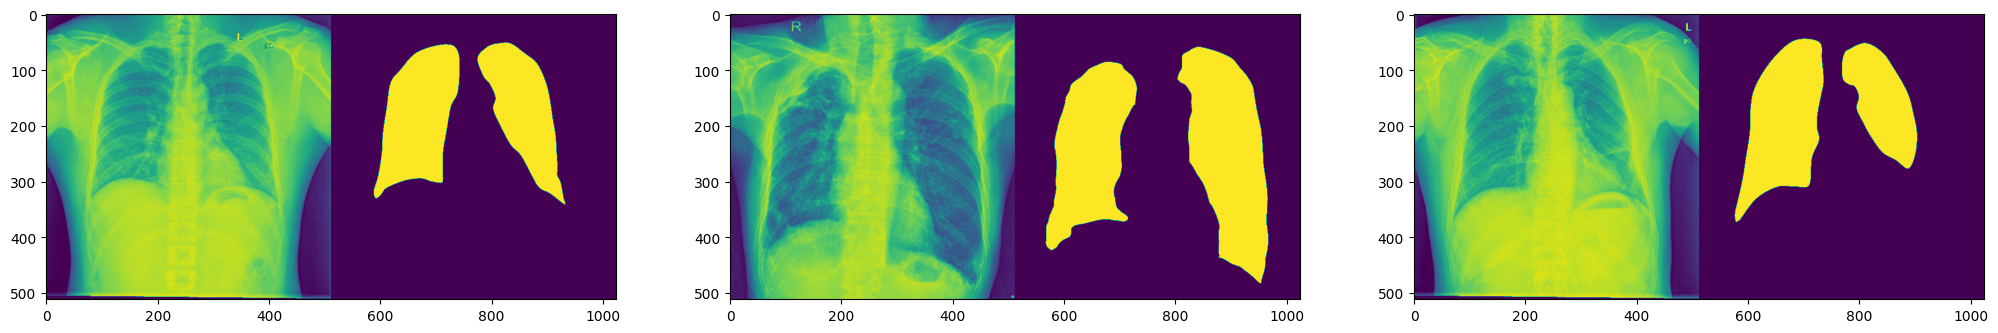

testing set


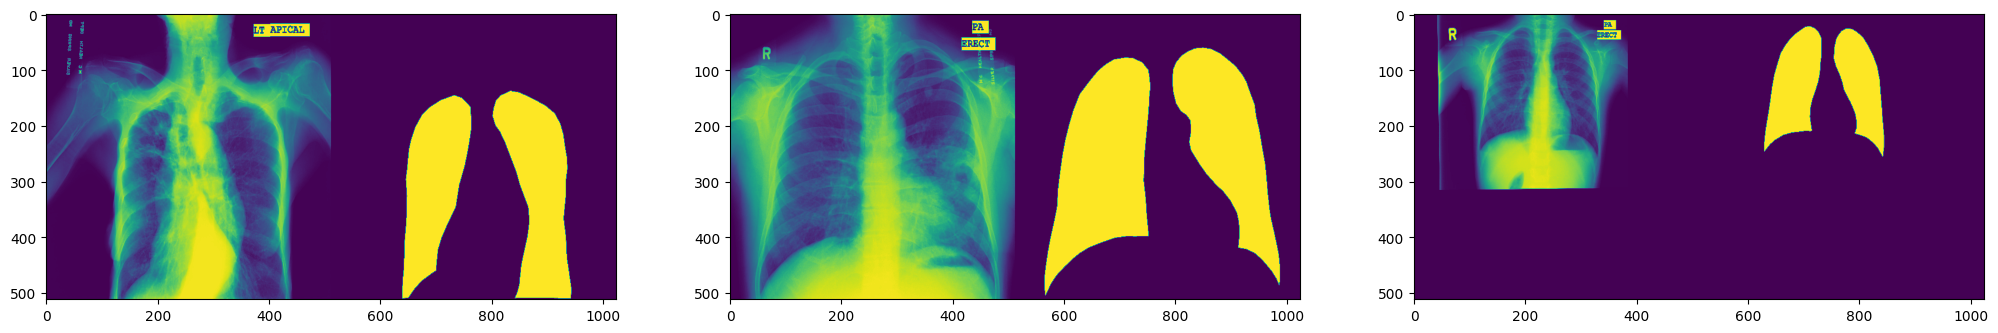

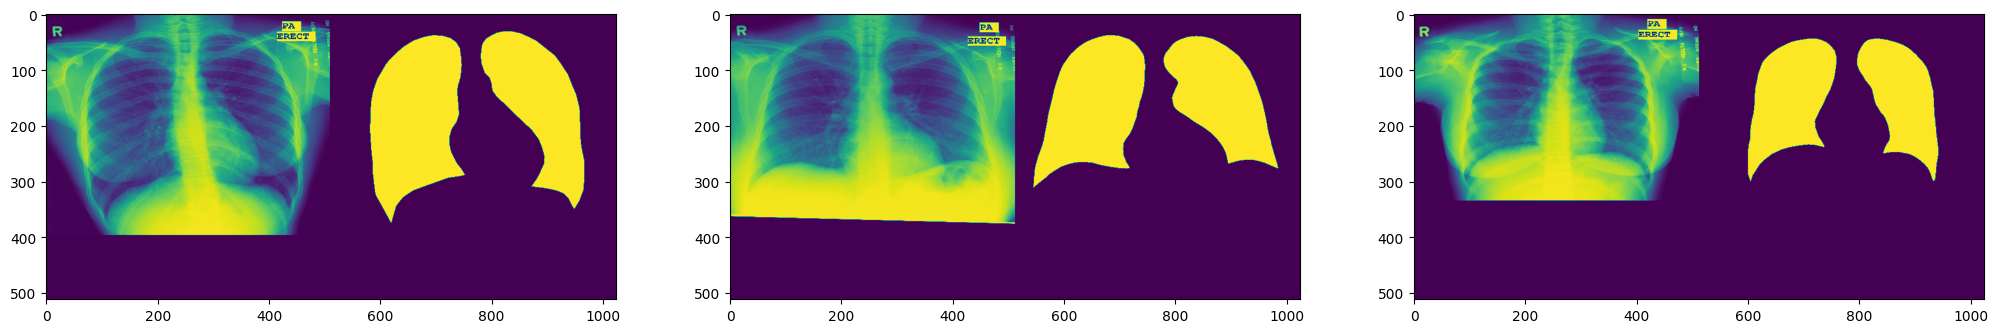

In [30]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [31]:
len(X_train)

566

In [32]:
len(y_train)

566

In [33]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

###Define the network and callbacks¶
I am going to use my favourite segmentation network - U-Nets. 

In [15]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


In [16]:
model = unet(input_size=(512, 512, 1))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
              metrics=[dice_coef, 'binary_accuracy'])
model.summary()


2024-07-09 15:42:31.503653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 15:42:31.623784: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import numpy as np

weight_path = "{}_weights.best.weights.h5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, verbose=1, mode='min', 
                                   min_delta=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_loss", mode="min", patience=15)

callbacks_list = [checkpoint, early, reduceLROnPlat]


In [18]:
# from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(learning_rate=2e-4), 
              loss=[dice_coef_loss], 
              metrics=[dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images - 127.0) / 127.0, 
                                                                        (mask > 127).astype(np.float32), 
                                                                        test_size=0.1, random_state=2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol, train_seg, 
                                                            test_size=0.1, 
                                                            random_state=2018)

loss_history = model.fit(x=train_vol,
                         y=train_seg,
                         batch_size=16,
                         epochs=50,
                         validation_data=(test_vol, test_seg),
                         callbacks=callbacks_list)

# clear_output()


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - binary_accuracy: 0.5675 - dice_coef: 0.3474 - loss: -0.3473 
Epoch 1: val_loss improved from inf to -0.50914, saving model to cxr_reg_weights.best.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 619s 17s/step - binary_accuracy: 0.5683 - dice_coef: 0.3481 - loss: -0.3480 - val_binary_accuracy: 0.6386 - val_dice_coef: 0.5091 - val_loss: -0.5091 - learning_rate: 2.0000e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - binary_accuracy: 0.6336 - dice_coef: 0.5224 - loss: -0.5224 
Epoch 2: val_loss improved from -0.50914 to -0.54235, saving model to cxr_reg_weights.best.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 628s 17s/step - binary_accuracy: 0.6339 - dice_coef: 0.5229 - loss: -0.5229 - val_binary_accuracy: 0.6788 - val_dice_coef: 0.5423 - val_loss: -0.5423 - learning_rate: 2.0000e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - binary_accuracy: 0.7568 - dice_coef: 0.6138 - loss: -0.6138 
Epoch 3: val_loss improved from -0.54235 to -0.68280

# Plot the metric and evaluate

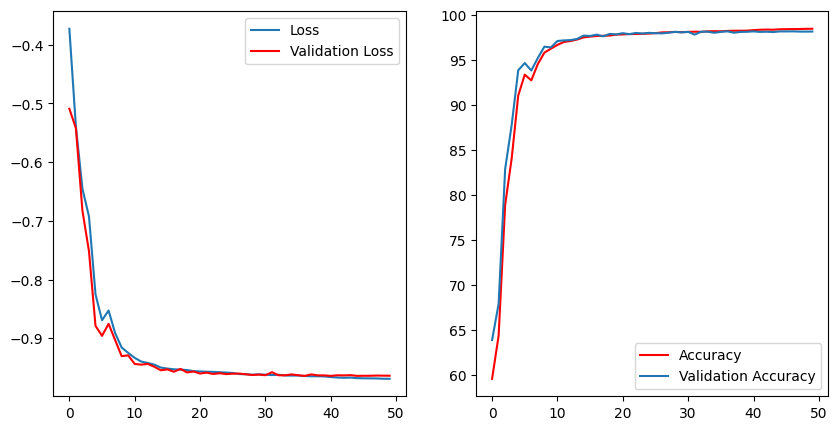

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss',color='red')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy',color = 'red')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

plt.savefig('training_results.png')  # Save the figure to the working directory
plt.show()